In [55]:
#pip install -U scikit-fuzzy

Membership Functions
 


In [56]:
from math import exp
import math
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy.membership import trimf,gauss2mf,gaussmf,gbellmf,sigmf,trapmf
import numpy as np 

class MembershipFunction:

    class Triangle:
        def __init__(self, a, b, c, min, max):
            self.a = a
            self.b = b
            self.c = c
            self.min = min
            self.max = max
            self.k = np.arange(min,max)

        def graph_function(self):
            mfx = fuzz.trimf(self.k, [self.a, self.b, self.c])
            plt.subplot(311)
            plt.plot(self.k,mfx,"r")

        def get_interval(self):
            return [self.min, self.max]

        def __call__(self, x):
            if x < self.min or x > self.max:
                return 0
            elif x <= self.a or x >= self.c:
                return 0
            elif self.a <= x <= self.b:
                return (x - self.a) / (self.b - self.a)
            elif self.b <= x <= self.c:
                return (self.c - x) / (self.c - self.b)

    class Trapesoid:
        def __init__(self, a, b, c, d, min, max):
            self.a = a
            self.b = b
            self.c = c
            self.d = d
            self.min = min
            self.max = max
            self.k = np.arange(min,max)

        def get_interval(self):
            return [self.min, self.max]

        def graph_function(self):
            mfx = fuzz.trapmf(self.k, [self.a, self.b, self.c,self.d])
            plt.subplot(311)
            plt.plot(self.k,mfx,"r")

        def __call__(self, x):
            if x < self.min or x > self.max:
                return 0
            elif x <= self.a or x >= self.d:
                return 0
            elif self.a <= x <= self.b:
                return (x - self.a) / (self.b - self.a)
            elif self.b <= x <= self.c:
                return 1
            elif self.c <= x <= self.d:
                return (self.d - x) / (self.d - self.c)

    class Gausiana:
        def __init__(self, width, center, min, max):
            self.width = width
            self.center = center
            self.min = min
            self.max = max
            self.k = np.arange(min,max)

        def get_interval(self):
            return [self.min, self.max]   

        def __call__(self, x):
            if x < self.min or x > self.max:
                return 0
            else:
                return exp(-0.5 * ((x - self.center) / self.width) ** 2)

    class Bell:
        def __init__(self, width, m, center, min, max):
            self.width = width
            self.m = m
            self.center = center
            self.min = min
            self.max = max
            self.k = np.arange(min,max)

        def get_interval(self):
            return [self.min, self.max]

        def __call__(self, x):
            if x < self.min or x > self.max:
                return 0
            else:
                return 1 / (1 + abs((x - self.center) / self.width) ** (2 * self.m))

    class Sigmoid:
        def __init__(self, m, center, min, max):
            self.m = m
            self.center = center
            self.min = min
            self.max = max
            self.k = np.arange(min,max)

        def get_interval(self):
            return [self.min, self.max]
        
        def graph_function(self):
            mfx = fuzz.sigmf(self.k, self.center, self.m)
            plt.subplot(311)
            plt.plot(self.k,mfx,"r")          

        def __call__(self, x):
            if x < self.min or x > self.max:
                return 0
            else:
                return 1 / (1 + exp(-self.m * (x - self.center)))

    class Singleton:
        def __init__(self, a, min, max):
            self.a = a
            self.min = min
            self.max = max
            self.k = np.arange(min,max) 

        def get_interval(self):
            return [self.min, self.max]
        
        def __call__(self, x):
            if x < self.min or x > self.max:
                return 0
            elif x == self.a:
                return 0
            else:
                return 1



 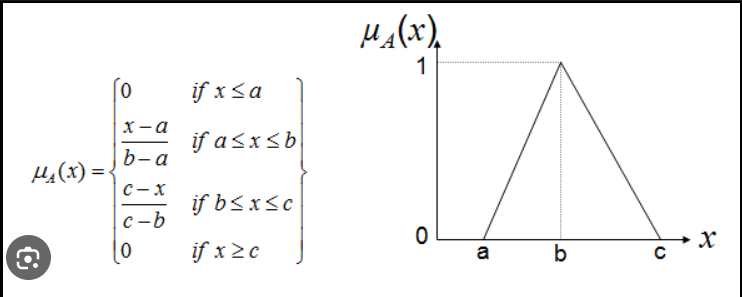

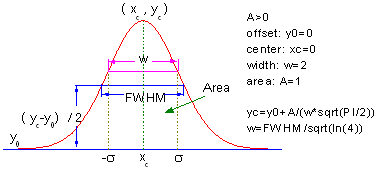

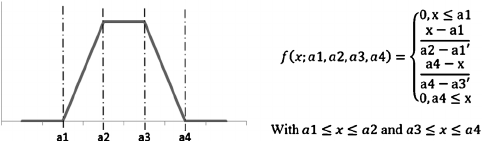

In [57]:
class FuzzyModelTsukamoto:
  def __init__(self):
      self.rules = []
      self.variables = {}
      self.input_values = {}
  
  def add_input(self, name : str , value : float):
      '''  Agrega una entrada al Modelo de Inferencia. Recibe el nombre 
        de la variable lingüística (string), su tipo (string) y su 
        valor (int). No devuelve nada.
        Se evalua value en la MF para cada uno de los estados en la
        variable linguistica por el metodo __call__ da 1 o 0.
        Nos dice a que valor liguistico tiene. '''
      self.input_values[name] = {
            'variable_type'  : name,
            'function_value' : {
                i : self.variables[name][i](value) for i in self.variables[name]
            }
        }

  def add_variable(self, var_type : str, states : list, membership_function : list):
        '''
        Agrega una variable al Modelo de Inferencia. Recibe el nombre 
        de la variable lingüística (string), los valores lingüísticos 
        (List<string>) y las funciones de pertenencia de cada valor 
        (List<MembershipFunction>). No devuelve nada.
        '''
        self.variables[var_type] = {
            states[i] : membership_function[i] for i in range(len(states))
        }

  def add_rule(self, precondition : str, postcondition : str):
    self.rules.append([precondition, postcondition])

  def get_x_mfvalue(self, mfvalue : float, MF : MembershipFunction.Sigmoid, step : float) -> float:
    x_arr = [_ for _ in range(MF.min, MF.max, step)]
    mf_arr = [MF(_) for _ in x_arr]

    closest_index = min(enumerate(mf_arr), key=lambda x: abs(x[1] - mfvalue))[0]
    closest_x = x_arr[closest_index]

    return closest_x
    
  def invmf(self,x, params, alpha, out_mf_type : str):
        if out_mf_type == 'sigmf':
            a = params[0]
            c = params[1]
            if alpha == 0.0 and a > 0.0:
                z = x[0]
            elif alpha == 1.0 and a > 0.0:
                z = x[-1]
            elif alpha == 0.0 and a < 0.0:
                z = x[-1]
            elif alpha == 1.0 and a < 0.0:
                z = x[0]
            else:
                z = c + math.log(alpha / (1 - alpha)) / a
        elif out_mf_type == 'smf':
            l = params[0]
            r = params[1]
            if alpha == 0.0:
                z = l
            elif 0 < alpha <= 0.5:
                z = l + (r - l) * math.sqrt(alpha / 2)
            elif 0.5 < alpha < 1.0:
                z = r - (r - l) * math.sqrt((1 - alpha) / 2)
            else:
                z = r
        elif out_mf_type == 'zmf':
            l = params[0]
            r = params[1]
            if alpha == 0.0:
                z = r
            elif 0.0 < alpha <= 0.5:
                z = r - (r - l) * math.sqrt(alpha / 2)
            elif 0.5 < alpha < 1.0:
                z = l + (r - l) * math.sqrt((1 - alpha) / 2)
            else:
                z = l
        elif out_mf_type == 'gaussmf':
            z = params[1]
        elif out_mf_type == 'gauss2mf':
            sig1 = params[0]
            m1 = params[1]
            sig2 = params[2]
            m2 = params[3]
            if alpha == 0.0:
                z = (m1 + m2 + (sig2 - sig1) * 10) / 2
            else:
                z = (m1 + m2 + (sig2 - sig1) * math.sqrt(-2 * math.log(alpha))) / 2
        elif out_mf_type == 'gbellmf':
            z = params[2]
        elif out_mf_type == 'trimf':
            a = params[0]
            b = params[1]
            c = params[2]
            z = (a + c + (2 * b - a - c) * alpha) / 2
        elif out_mf_type == 'trapmf':
            a = params[0]
            b = params[1]
            c = params[2]
            d = params[3]
            z = (a + d + (b + c - a - d) * alpha) / 2
        elif out_mf_type == 'sechmf':
            z = params[2]
        elif out_mf_type == 'tanhmf':
            z = params[2]
        elif out_mf_type == 'logmf':
            z = params[2]
        elif out_mf_type == 'cauchymf':
            z = params[2]
        else:
            raise ValueError('Unknown Membership Functions!')
        
        return z

  def solve_tsuk(self):
    numerator, denominator = 0, 0
    for rule in self.rules:
      #precond_current_temp = rule[0].split()[3]
      #precond_delta_temp = rule[0].split()[7]
      postcond_energy = rule[1].split()[2]
      mfvalue_current_temp = self.input_values["current_temperature"]["function_value"][rule[0].split()[3]]
      mfvalue_delta_temp = self.input_values["delta_temperature"]["function_value"][rule[0].split()[7]]
      logic_op = rule[0].split()[4]
    
      if logic_op == "and":
        w = min(mfvalue_current_temp, mfvalue_delta_temp)
      else:
        w = max(mfvalue_current_temp, mfvalue_delta_temp)

      MF = self.variables[rule[1].split()[0]][postcond_energy]
      x = [_ for _ in range(MF.min, MF.max, 1)]
      vals = [0.07, 50]
      z = self.invmf(x, vals, w,'sigmf')
      #z = self.get_x_mfvalue(w, self.variables[rule[1].split()[0]][postcond_energy], 1)

      numerator += w*z
      denominator += w    
        
    if denominator != 0:
      fuzzy_out = numerator / denominator
    else:
      fuzzy_out = 0

    return fuzzy_out

In [58]:
FM = FuzzyModelTsukamoto()

# Reglas Difusas para un FIS de consumo de energia de un horno

In [59]:
# Se agrega la variable linguistica para la temperatura del horno actual
FM.add_variable("current_temperature", 
                
                ["Cold","Warm", "Hot","Very_Hot"], 
      
              [ MembershipFunction.Triangle(0,12.5, 25,0,25), 
                MembershipFunction.Triangle(20,35,50,20,50), 
                MembershipFunction.Triangle(45,60,75,45,75), 
                MembershipFunction.Triangle(70,85,100,70,100)  ]
              )

# Agregar variable linguistica para la tasa de cambio de la temperatura
FM.add_variable("delta_temperature", 
                ["Rapidly_decreasing",
                 "Decreasing",
                 "Stable",
                 "Increasing",
                 "Rapidly_increasing"],
                [MembershipFunction.Trapesoid(-10,-5,-3,0,-10, 0),
              MembershipFunction.Triangle(-4,-2,0,-4,0),
              MembershipFunction.Triangle(-1,0,1,-1,1),
              MembershipFunction.Triangle(0,2,4,0,0),
              MembershipFunction.Trapesoid(0,3,5,7,0,7) ])

# Agregar var. linguistica para la energia del horno
FM.add_variable("oven_energy",["Off", "Low", "Medium", "High","Very_High"],
                [MembershipFunction.Sigmoid(.07,50,0, 20) ,
                MembershipFunction.Sigmoid(.07,50,20, 40) ,
                MembershipFunction.Sigmoid(.07,50,40, 60) ,
                MembershipFunction.Sigmoid(.07,50,60, 80) , 
                MembershipFunction.Sigmoid(.07,50,80, 100)])

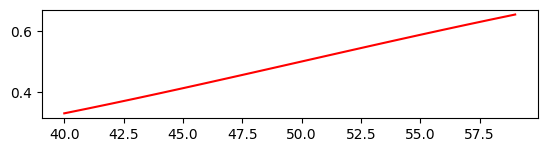

In [60]:
FM.variables["oven_energy"]["Medium"].graph_function()

In [61]:
FM.add_input("current_temperature", 30)
FM.add_input("delta_temperature", 3)

In [62]:
FM.add_rule("IF current_temperature is Cold and delta_temperature is Rapidly_increasing", "oven_energy is Off")
FM.add_rule("IF current_temperature is Cold and delta_temperature is Decreasing", "oven_energy is Low")
FM.add_rule("IF current_temperature is Cold and delta_temperature is Stable", "oven_energy is Medium")
FM.add_rule("IF current_temperature is Cold and delta_temperature is Increasing", "oven_energy is High")

FM.add_rule("IF current_temperature is Cold and delta_temperature is Rapidly_increasing", "oven_energy is Very_High")
FM.add_rule("IF current_temperature is Warm and delta_temperature is Rapidly_decreasing", "oven_energy is Off")
FM.add_rule("IF current_temperature is Warm and delta_temperature is Decreasing", "oven_energy is Low")
FM.add_rule("IF current_temperature is Warm and delta_temperature is Stable", "oven_energy is Medium")

FM.add_rule("IF current_temperature is Warm and delta_temperature is Increasing", "oven_energy is High")
FM.add_rule("IF current_temperature is Warm and delta_temperature is Rapidly_increasing", "oven_energy is Medium")
FM.add_rule("IF current_temperature is Warm and delta_temperature is Rapidly_decreasing","oven_energy is Low")
FM.add_rule("IF current_temperature is Warm and delta_temperature is Decreasing", "oven_energy is Medium")

FM.add_rule("IF current_temperature is Hot and delta_temperature is Stable",  "oven_energy is High")
FM.add_rule("IF current_temperature is Hot and delta_temperature is Increasing", "oven_energy is Very_High")
FM.add_rule("IF current_temperature is Hot and delta_temperature is Rapidly_increasing",  "oven_energy is Very_High")
FM.add_rule("IF current_temperature is Very_Hot and delta_temperature is Rapidly_decreasing", "oven_energy is Medium")

FM.add_rule("IF current_temperature is Very_Hot and delta_temperature is Decreasing", "oven_energy is High")
FM.add_rule("IF current_temperature is Very_Hot and delta_temperature is Stable", "oven_energy is Very_High")
FM.add_rule("IF current_temperature is Very_Hot and delta_temperature is Increasing", "oven_energy is Very_High")
FM.add_rule("IF current_temperature is Very_Hot and delta_temperature is Rapidly_increasing", "oven_energy is Very_High")

In [63]:
print(f"El consumo de energia es de {round(FM.solve_tsuk(),4)}%")

El consumo de energia es de 59.9021%
